In [44]:
import numpy as np 
import pandas as pd 
import re
import nltk 
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import TweetTokenizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score, precision_score

from wordcloud import WordCloud,STOPWORDS

In [2]:
#читаем файл
data = pd.read_csv("Tweets.csv")

In [3]:
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [6]:
plot_size = plt.rcParams["figure.figsize"] 
print(plot_size[0]) 
print(plot_size[1])

plot_size[0] = 8
plot_size[1] = 6
plt.rcParams["figure.figsize"] = plot_size 

8.0
6.0


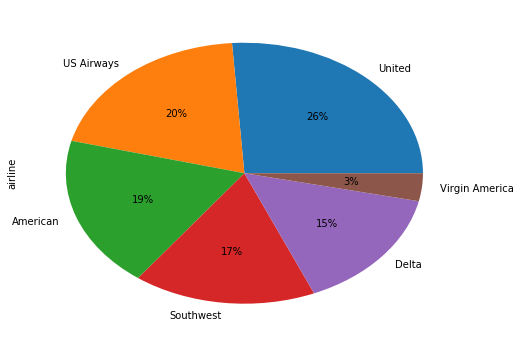

In [7]:
data.airline.value_counts().plot(kind='pie', autopct='%1.0f%%')

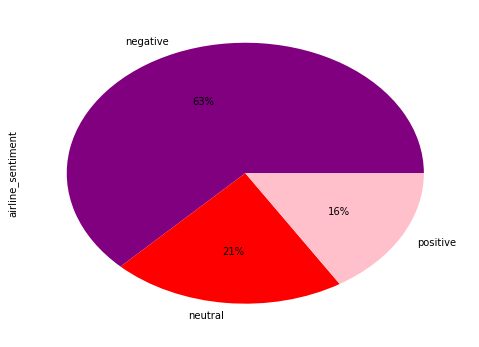

In [8]:
data.airline_sentiment.value_counts().plot(kind='pie', autopct='%1.0f%%', colors=["purple", "red", "pink"])

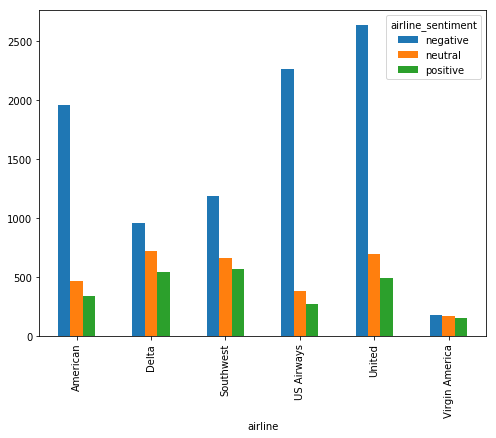

In [9]:
airline_sentiment = data.groupby(['airline', 'airline_sentiment']).airline_sentiment.count().unstack()
airline_sentiment.plot(kind='bar')

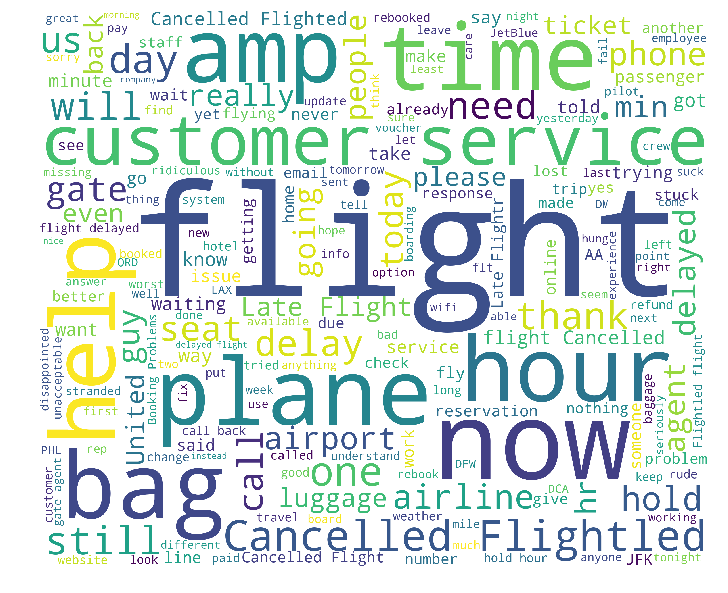

In [45]:
new_data=data[data['airline_sentiment']=='negative']
words = ' '.join(new_data['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='white',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

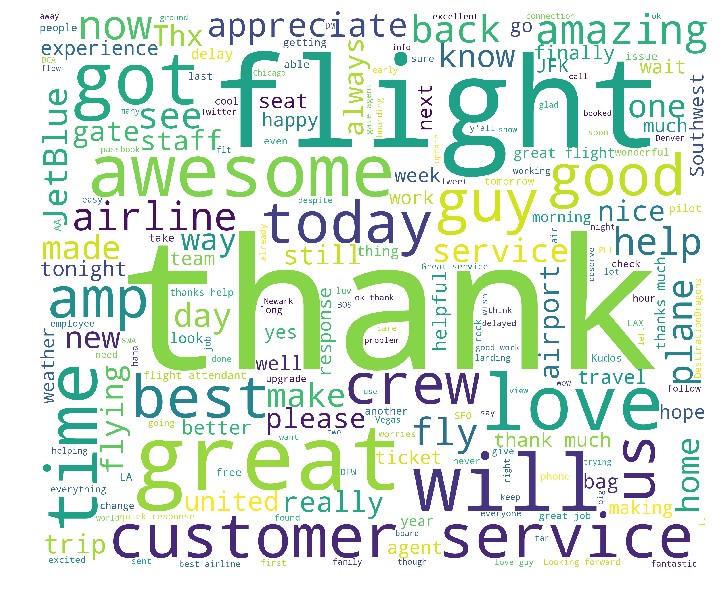

In [47]:
new_data=data[data['airline_sentiment']=='positive']
words = ' '.join(new_data['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='white',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [30]:
#чистим данные
data_clean = data.copy()
data_clean = data_clean[data_clean['airline_sentiment_confidence'] > 0.65]
data_clean['sentiment'] = data_clean['airline_sentiment'].\
    apply(lambda x:  1 if x=='negative'else 0)

data_clean['text_clean'] = data_clean['text'].apply(lambda x: BeautifulSoup(x, "lxml").text)

In [32]:
data_clean['sentiment'] = data_clean['airline_sentiment'].apply(lambda x: 1 if x=='negative' else 0 if x=='neutral' else 2 )

In [33]:
data_clean = data_clean.loc[:, ['text_clean', 'sentiment']]

In [34]:
data_clean.head()

,text_clean,sentiment
0,@VirginAmerica What @dhepburn said.,0
2,@VirginAmerica I didn't today... Must mean I n...,0
3,@VirginAmerica it's really aggressive to blast...,1
4,@VirginAmerica and it's a really big bad thing...,1
5,@VirginAmerica seriously would pay $30 a fligh...,1


In [35]:
#разделяем на тренировочный сет и тестовый сет
train, test = train_test_split(data_clean, test_size=0.2, random_state=1)
X_train = train['text_clean'].values
X_test = test['text_clean'].values
y_train = train['sentiment']
y_test = test['sentiment']

In [36]:
def tokenize(text): 
    tknzr = TweetTokenizer()
    return tknzr.tokenize(text)

def stem(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

en_stopwords = set(stopwords.words("english")) 

vectorizer = CountVectorizer(
    analyzer = 'word',
    tokenizer = tokenize,
    lowercase = True,
    ngram_range=(1, 1),
    stop_words = en_stopwords)

In [37]:
#начинаем искать лучшие параметры для модели
kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [38]:
np.random.seed(1)

pipeline_svm = make_pipeline(vectorizer, 
                            SVC(probability=True, kernel="linear", class_weight="balanced"))

grid_svm = GridSearchCV(pipeline_svm,
                    param_grid = {'svc__C': [0.01, 0.1, 1]}, 
                    cv = kfolds,
                    scoring="roc_auc",
                    verbose=1,   
                    n_jobs=-1) 

grid_svm.fit(X_train, y_train)
grid_svm.score(X_test, y_test)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/anaconda3/lib/python3.6/runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
/anaconda3/lib/python3.6/runpy.py in _run_code(code=<code object <module> at 0x10d8d2ed0, file "/ana...3.6/site-packages/ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/anaconda3/lib/python3.6/site-packages/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x10d8d2ed0, file "/ana...3.6/site-packages/ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/anaconda3/lib/python3.6/site-packages/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    481         if self.poller is not None:
    482             self.poller.start()
    483         self.kernel.start()
    484         self.io_loop = ioloop.IOLoop.current()
    485         try:
--> 486             self.io_loop.start()
        self.io_loop.start = <bound method BaseAsyncIOLoop.start of <tornado.platform.asyncio.AsyncIOMainLoop object>>
    487         except KeyboardInterrupt:
    488             pass
    489 
    490 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/anaconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py in start(self=<tornado.platform.asyncio.AsyncIOMainLoop object>)
    122         except (RuntimeError, AssertionError):
    123             old_loop = None
    124         try:
    125             self._setup_logging()
    126             asyncio.set_event_loop(self.asyncio_loop)
--> 127             self.asyncio_loop.run_forever()
        self.asyncio_loop.run_forever = <bound method BaseEventLoop.run_forever of <_Uni...EventLoop running=True closed=False debug=False>>
    128         finally:
    129             asyncio.set_event_loop(old_loop)
    130 
    131     def stop(self):

...........................................................................
/anaconda3/lib/python3.6/asyncio/base_events.py in run_forever(self=<_UnixSelectorEventLoop running=True closed=False debug=False>)
    417             sys.set_asyncgen_hooks(firstiter=self._asyncgen_firstiter_hook,
    418                                    finalizer=self._asyncgen_finalizer_hook)
    419         try:
    420             events._set_running_loop(self)
    421             while True:
--> 422                 self._run_once()
        self._run_once = <bound method BaseEventLoop._run_once of <_UnixS...EventLoop running=True closed=False debug=False>>
    423                 if self._stopping:
    424                     break
    425         finally:
    426             self._stopping = False

...........................................................................
/anaconda3/lib/python3.6/asyncio/base_events.py in _run_once(self=<_UnixSelectorEventLoop running=True closed=False debug=False>)
   1427                         logger.warning('Executing %s took %.3f seconds',
   1428                                        _format_handle(handle), dt)
   1429                 finally:
   1430                     self._current_handle = None
   1431             else:
-> 1432                 handle._run()
        handle._run = <bound method Handle._run of <Handle BaseAsyncIOLoop._handle_events(15, 1)>>
   1433         handle = None  # Needed to break cycles when an exception occurs.
   1434 
   1435     def _set_coroutine_wrapper(self, enabled):
   1436         try:

...........................................................................
/anaconda3/lib/python3.6/asyncio/events.py in _run(self=<Handle BaseAsyncIOLoop._handle_events(15, 1)>)
    140             self._callback = None
    141             self._args = None
    142 
    143     def _run(self):
    144         try:
--> 145             self._callback(*self._args)
        self._callback = <bound method BaseAsyncIOLoop._handle_events of <tornado.platform.asyncio.AsyncIOMainLoop object>>
        self._args = (15, 1)
    146         except Exception as exc:
    147             cb = _format_callback_source(self._callback, self._args)
    148             msg = 'Exception in callback {}'.format(cb)
    149             context = {

...........................................................................
/anaconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py in _handle_events(self=<tornado.platform.asyncio.AsyncIOMainLoop object>, fd=15, events=1)
    112             self.writers.remove(fd)
    113         del self.handlers[fd]
    114 
    115     def _handle_events(self, fd, events):
    116         fileobj, handler_func = self.handlers[fd]
--> 117         handler_func(fileobj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fileobj = <zmq.sugar.socket.Socket object>
        events = 1
    118 
    119     def start(self):
    120         try:
    121             old_loop = asyncio.get_event_loop()

...........................................................................
/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    271         # Fast path when there are no active contexts.
    272         def null_wrapper(*args, **kwargs):
    273             try:
    274                 current_state = _state.contexts
    275                 _state.contexts = cap_contexts[0]
--> 276                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    277             finally:
    278                 _state.contexts = current_state
    279         null_wrapper._wrapped = True
    280         return null_wrapper

...........................................................................
/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    445             return
    446         zmq_events = self.socket.EVENTS
    447         try:
    448             # dispatch events:
    449             if zmq_events & zmq.POLLIN and self.receiving():
--> 450                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    451                 if not self.socket:
    452                     return
    453             if zmq_events & zmq.POLLOUT and self.sending():
    454                 self._handle_send()

...........................................................................
/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    475             else:
    476                 raise
    477         else:
    478             if self._recv_callback:
    479                 callback = self._recv_callback
--> 480                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    481         
    482 
    483     def _handle_send(self):
    484         """Handle a send event."""

...........................................................................
/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    427         close our socket."""
    428         try:
    429             # Use a NullContext to ensure that all StackContexts are run
    430             # inside our blanket exception handler rather than outside.
    431             with stack_context.NullContext():
--> 432                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    433         except:
    434             gen_log.error("Uncaught exception in ZMQStream callback",
    435                           exc_info=True)
    436             # Re-raise the exception so that IOLoop.handle_callback_exception

...........................................................................
/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    271         # Fast path when there are no active contexts.
    272         def null_wrapper(*args, **kwargs):
    273             try:
    274                 current_state = _state.contexts
    275                 _state.contexts = cap_contexts[0]
--> 276                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    277             finally:
    278                 _state.contexts = current_state
    279         null_wrapper._wrapped = True
    280         return null_wrapper

...........................................................................
/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': 'np.random.seed(1)\n\npipeline_svm = make_pipeline(...(X_train, y_train)\ngrid_svm.score(X_test, y_test)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2019, 11, 13, 21, 38, 10, 826735, tzinfo=tzutc()), 'msg_id': '66c0f6052203431f8b92fe5445783198', 'msg_type': 'execute_request', 'session': '22cb427eb15e4bf99158847b23ff1ff9', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '66c0f6052203431f8b92fe5445783198', 'msg_type': 'execute_request', 'parent_header': {}})
    228             self.log.warn("Unknown message type: %r", msg_type)
    229         else:
    230             self.log.debug("%s: %s", msg_type, msg)
    231             self.pre_handler_hook()
    232             try:
--> 233                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'22cb427eb15e4bf99158847b23ff1ff9']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': 'np.random.seed(1)\n\npipeline_svm = make_pipeline(...(X_train, y_train)\ngrid_svm.score(X_test, y_test)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2019, 11, 13, 21, 38, 10, 826735, tzinfo=tzutc()), 'msg_id': '66c0f6052203431f8b92fe5445783198', 'msg_type': 'execute_request', 'session': '22cb427eb15e4bf99158847b23ff1ff9', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '66c0f6052203431f8b92fe5445783198', 'msg_type': 'execute_request', 'parent_header': {}}
    234             except Exception:
    235                 self.log.error("Exception in message handler:", exc_info=True)
    236             finally:
    237                 self.post_handler_hook()

...........................................................................
/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'22cb427eb15e4bf99158847b23ff1ff9'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': 'np.random.seed(1)\n\npipeline_svm = make_pipeline(...(X_train, y_train)\ngrid_svm.score(X_test, y_test)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2019, 11, 13, 21, 38, 10, 826735, tzinfo=tzutc()), 'msg_id': '66c0f6052203431f8b92fe5445783198', 'msg_type': 'execute_request', 'session': '22cb427eb15e4bf99158847b23ff1ff9', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '66c0f6052203431f8b92fe5445783198', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='np.random.seed(1)\n\npipeline_svm = make_pipeline(...(X_train, y_train)\ngrid_svm.score(X_test, y_test)', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    203 
    204         self._forward_input(allow_stdin)
    205 
    206         reply_content = {}
    207         try:
--> 208             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = 'np.random.seed(1)\n\npipeline_svm = make_pipeline(...(X_train, y_train)\ngrid_svm.score(X_test, y_test)'
        store_history = True
        silent = False
    209         finally:
    210             self._restore_input()
    211 
    212         if res.error_before_exec is not None:

...........................................................................
/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('np.random.seed(1)\n\npipeline_svm = make_pipeline(...(X_train, y_train)\ngrid_svm.score(X_test, y_test)',), **kwargs={'silent': False, 'store_history': True})
    532             )
    533         self.payload_manager.write_payload(payload)
    534 
    535     def run_cell(self, *args, **kwargs):
    536         self._last_traceback = None
--> 537         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('np.random.seed(1)\n\npipeline_svm = make_pipeline(...(X_train, y_train)\ngrid_svm.score(X_test, y_test)',)
        kwargs = {'silent': False, 'store_history': True}
    538 
    539     def _showtraceback(self, etype, evalue, stb):
    540         # try to preserve ordering of tracebacks and print statements
    541         sys.stdout.flush()

...........................................................................
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='np.random.seed(1)\n\npipeline_svm = make_pipeline(...(X_train, y_train)\ngrid_svm.score(X_test, y_test)', store_history=True, silent=False, shell_futures=True)
   2657         -------
   2658         result : :class:`ExecutionResult`
   2659         """
   2660         try:
   2661             result = self._run_cell(
-> 2662                 raw_cell, store_history, silent, shell_futures)
        raw_cell = 'np.random.seed(1)\n\npipeline_svm = make_pipeline(...(X_train, y_train)\ngrid_svm.score(X_test, y_test)'
        store_history = True
        silent = False
        shell_futures = True
   2663         finally:
   2664             self.events.trigger('post_execute')
   2665             if not silent:
   2666                 self.events.trigger('post_run_cell', result)

...........................................................................
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in _run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='np.random.seed(1)\n\npipeline_svm = make_pipeline(...(X_train, y_train)\ngrid_svm.score(X_test, y_test)', store_history=True, silent=False, shell_futures=True)
   2780                 self.displayhook.exec_result = result
   2781 
   2782                 # Execute the user code
   2783                 interactivity = 'none' if silent else self.ast_node_interactivity
   2784                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2785                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2786                 
   2787                 self.last_execution_succeeded = not has_raised
   2788                 self.last_execution_result = result
   2789 

...........................................................................
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Expr object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Expr object>, <_ast.Expr object>], cell_name='<ipython-input-38-8a78fed5743d>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 125f867f0, execution_...rue silent=False shell_futures=True> result=None>)
   2898 
   2899         try:
   2900             for i, node in enumerate(to_run_exec):
   2901                 mod = ast.Module([node])
   2902                 code = compiler(mod, cell_name, "exec")
-> 2903                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x125452f60, file "<ipython-input-38-8a78fed5743d>", line 13>
        result = <ExecutionResult object at 125f867f0, execution_...rue silent=False shell_futures=True> result=None>
   2904                     return True
   2905 
   2906             for i, node in enumerate(to_run_interactive):
   2907                 mod = ast.Interactive([node])

...........................................................................
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x125452f60, file "<ipython-input-38-8a78fed5743d>", line 13>, result=<ExecutionResult object at 125f867f0, execution_...rue silent=False shell_futures=True> result=None>)
   2958         outflag = True  # happens in more places, so it's easier as default
   2959         try:
   2960             try:
   2961                 self.hooks.pre_run_code_hook()
   2962                 #rprint('Running code', repr(code_obj)) # dbg
-> 2963                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x125452f60, file "<ipython-input-38-8a78fed5743d>", line 13>
        self.user_global_ns = {'BeautifulSoup': <class 'bs4.BeautifulSoup'>, 'CountVectorizer': <class 'sklearn.feature_extraction.text.CountVectorizer'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', 'import numpy as np \nimport pandas as pd \nimport ...rix, roc_auc_score, recall_score, precision_score', '#читаем файл\ndata = pd.read_csv("Tweets.csv")', 'data.head()', 'plot_size = plt.rcParams["figure.figsize"] \nprin...] = 7\nplt.rcParams["figure.figsize"] = plot_size ', 'plot_size = plt.rcParams["figure.figsize"] \nprin...] = 6\nplt.rcParams["figure.figsize"] = plot_size ', 'plot_size = plt.rcParams["figure.figsize"] \nprin...] = 6\nplt.rcParams["figure.figsize"] = plot_size ', "data.airline.value_counts().plot(kind='pie', autopct='%1.0f%%')", 'data.airline_sentiment.value_counts().plot(kind=...opct=\'%1.0f%%\', colors=["purple", "red", "pink"])', "airline_sentiment = data.groupby(['airline', 'ai...nt().unstack()\nairline_sentiment.plot(kind='bar')", '#чистим данные\ndata_clean = data.copy()\ndata_cle...\'].apply(lambda x: BeautifulSoup(x, "lxml").text)', "data_clean['sentiment'] = data_clean['airline_sentiment'].apply(lambda x: 1 if x=='negative' else 0)", "data_clean = data_clean.loc[:, ['text_clean', 'sentiment']]", 'data_clean.head()', "#разделяем на тренировочный сет и тестовый сет\nt...n = train['sentiment']\ny_test = test['sentiment']", 'def tokenize(text): \n    tknzr = TweetTokenizer(...gram_range=(1, 1),\n    stop_words = en_stopwords)', '#начинаем искать лучшие параметры для модели\nkfo...edKFold(n_splits=5, shuffle=True, random_state=1)', 'np.random.seed(1)\n\npipeline_svm = make_pipeline(...(X_train, y_train)\ngrid_svm.score(X_test, y_test)', 'grid_svm.best_params_', 'grid_svm.best_score_', ...], 'LogisticRegression': <class 'sklearn.linear_model.logistic.LogisticRegression'>, 'Out': {3:              tweet_id airline_sentiment  airline...0800            NaN  Pacific Time (US & Canada)  , 7: <matplotlib.axes._subplots.AxesSubplot object>, 8: <matplotlib.axes._subplots.AxesSubplot object>, 9: <matplotlib.axes._subplots.AxesSubplot object>, 13:                                           text_c...ica seriously would pay $30 a fligh...          1, 17: 0.9188979138877743, 18: {'svc__C': 0.1}, 19: 0.9030710357013573, 21: {'acc': 0.8337605272793849, 'auc': 0.9189003237673165, 'f1': 0.8690888119953863, 'precision': 0.9133333333333333, 'recall': 0.828932893289329}, 34:                                           text_c...ica seriously would pay $30 a fligh...          1}, 'Pipeline': <class 'sklearn.pipeline.Pipeline'>, 'SVC': <class 'sklearn.svm.classes.SVC'>, 'SnowballStemmer': <class 'nltk.stem.snowball.SnowballStemmer'>, 'StratifiedKFold': <class 'sklearn.model_selection._split.StratifiedKFold'>, ...}
        self.user_ns = {'BeautifulSoup': <class 'bs4.BeautifulSoup'>, 'CountVectorizer': <class 'sklearn.feature_extraction.text.CountVectorizer'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', 'import numpy as np \nimport pandas as pd \nimport ...rix, roc_auc_score, recall_score, precision_score', '#читаем файл\ndata = pd.read_csv("Tweets.csv")', 'data.head()', 'plot_size = plt.rcParams["figure.figsize"] \nprin...] = 7\nplt.rcParams["figure.figsize"] = plot_size ', 'plot_size = plt.rcParams["figure.figsize"] \nprin...] = 6\nplt.rcParams["figure.figsize"] = plot_size ', 'plot_size = plt.rcParams["figure.figsize"] \nprin...] = 6\nplt.rcParams["figure.figsize"] = plot_size ', "data.airline.value_counts().plot(kind='pie', autopct='%1.0f%%')", 'data.airline_sentiment.value_counts().plot(kind=...opct=\'%1.0f%%\', colors=["purple", "red", "pink"])', "airline_sentiment = data.groupby(['airline', 'ai...nt().unstack()\nairline_sentiment.plot(kind='bar')", '#чистим данные\ndata_clean = data.copy()\ndata_cle...\'].apply(lambda x: BeautifulSoup(x, "lxml").text)', "data_clean['sentiment'] = data_clean['airline_sentiment'].apply(lambda x: 1 if x=='negative' else 0)", "data_clean = data_clean.loc[:, ['text_clean', 'sentiment']]", 'data_clean.head()', "#разделяем на тренировочный сет и тестовый сет\nt...n = train['sentiment']\ny_test = test['sentiment']", 'def tokenize(text): \n    tknzr = TweetTokenizer(...gram_range=(1, 1),\n    stop_words = en_stopwords)', '#начинаем искать лучшие параметры для модели\nkfo...edKFold(n_splits=5, shuffle=True, random_state=1)', 'np.random.seed(1)\n\npipeline_svm = make_pipeline(...(X_train, y_train)\ngrid_svm.score(X_test, y_test)', 'grid_svm.best_params_', 'grid_svm.best_score_', ...], 'LogisticRegression': <class 'sklearn.linear_model.logistic.LogisticRegression'>, 'Out': {3:              tweet_id airline_sentiment  airline...0800            NaN  Pacific Time (US & Canada)  , 7: <matplotlib.axes._subplots.AxesSubplot object>, 8: <matplotlib.axes._subplots.AxesSubplot object>, 9: <matplotlib.axes._subplots.AxesSubplot object>, 13:                                           text_c...ica seriously would pay $30 a fligh...          1, 17: 0.9188979138877743, 18: {'svc__C': 0.1}, 19: 0.9030710357013573, 21: {'acc': 0.8337605272793849, 'auc': 0.9189003237673165, 'f1': 0.8690888119953863, 'precision': 0.9133333333333333, 'recall': 0.828932893289329}, 34:                                           text_c...ica seriously would pay $30 a fligh...          1}, 'Pipeline': <class 'sklearn.pipeline.Pipeline'>, 'SVC': <class 'sklearn.svm.classes.SVC'>, 'SnowballStemmer': <class 'nltk.stem.snowball.SnowballStemmer'>, 'StratifiedKFold': <class 'sklearn.model_selection._split.StratifiedKFold'>, ...}
   2964             finally:
   2965                 # Reset our crash handler in place
   2966                 sys.excepthook = old_excepthook
   2967         except SystemExit as e:

...........................................................................
/Users/aleksandraod/<ipython-input-38-8a78fed5743d> in <module>()
      8                     cv = kfolds,
      9                     scoring="roc_auc",
     10                     verbose=1,   
     11                     n_jobs=-1) 
     12 
---> 13 grid_svm.fit(X_train, y_train)
     14 grid_svm.score(X_test, y_test)

...........................................................................
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py in fit(self=GridSearchCV(cv=StratifiedKFold(n_splits=5, rand...train_score='warn', scoring='roc_auc', verbose=1), X=array(["@united flight Cancelled Flightled,  and...iate your prompt response!"],
      dtype=object), y=1241     1
4711     1
9943     2
6455     0
1128...   2
Name: sentiment, Length: 10920, dtype: int64, groups=None, **fit_params={})
    634                                   return_train_score=self.return_train_score,
    635                                   return_n_test_samples=True,
    636                                   return_times=True, return_parameters=False,
    637                                   error_score=self.error_score)
    638           for parameters, (train, test) in product(candidate_params,
--> 639                                                    cv.split(X, y, groups)))
        cv.split = <bound method StratifiedKFold.split of StratifiedKFold(n_splits=5, random_state=1, shuffle=True)>
        X = array(["@united flight Cancelled Flightled,  and...iate your prompt response!"],
      dtype=object)
        y = 1241     1
4711     1
9943     2
6455     0
1128...   2
Name: sentiment, Length: 10920, dtype: int64
        groups = None
    640 
    641         # if one choose to see train score, "out" will contain train score info
    642         if self.return_train_score:
    643             (train_score_dicts, test_score_dicts, test_sample_counts, fit_time,

...........................................................................
/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object BaseSearchCV.fit.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Thu Nov 14 00:39:30 2019
PID: 5558                               Python 3.6.5: /anaconda3/bin/python
...........................................................................
/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (Pipeline(memory=None,
     steps=[('countvectori...e, shrinking=True,
  tol=0.001, verbose=False))]), array(["@united flight Cancelled Flightled,  and...iate your prompt response!"],
      dtype=object), 1241     1
4711     1
9943     2
6455     0
1128...   2
Name: sentiment, Length: 10920, dtype: int64, {'score': make_scorer(roc_auc_score, needs_threshold=True)}, array([    0,     1,     3, ..., 10917, 10918, 10919]), array([    2,     7,    11, ..., 10903, 10908, 10915]), 1, {'svc__C': 0.01}), {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn'})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (Pipeline(memory=None,
     steps=[('countvectori...e, shrinking=True,
  tol=0.001, verbose=False))]), array(["@united flight Cancelled Flightled,  and...iate your prompt response!"],
      dtype=object), 1241     1
4711     1
9943     2
6455     0
1128...   2
Name: sentiment, Length: 10920, dtype: int64, {'score': make_scorer(roc_auc_score, needs_threshold=True)}, array([    0,     1,     3, ..., 10917, 10918, 10919]), array([    2,     7,    11, ..., 10903, 10908, 10915]), 1, {'svc__C': 0.01})
        kwargs = {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn'}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py in _fit_and_score(estimator=Pipeline(memory=None,
     steps=[('countvectori...e, shrinking=True,
  tol=0.001, verbose=False))]), X=array(["@united flight Cancelled Flightled,  and...iate your prompt response!"],
      dtype=object), y=1241     1
4711     1
9943     2
6455     0
1128...   2
Name: sentiment, Length: 10920, dtype: int64, scorer={'score': make_scorer(roc_auc_score, needs_threshold=True)}, train=array([    0,     1,     3, ..., 10917, 10918, 10919]), test=array([    2,     7,    11, ..., 10903, 10908, 10915]), verbose=1, parameters={'svc__C': 0.01}, fit_params={}, return_train_score='warn', return_parameters=False, return_n_test_samples=True, return_times=True, error_score='raise')
    483                              " make sure that it has been spelled correctly.)")
    484 
    485     else:
    486         fit_time = time.time() - start_time
    487         # _score will return dict if is_multimetric is True
--> 488         test_scores = _score(estimator, X_test, y_test, scorer, is_multimetric)
        test_scores = {}
        estimator = Pipeline(memory=None,
     steps=[('countvectori...e, shrinking=True,
  tol=0.001, verbose=False))])
        X_test = array(['@USAirways Ann Marie at LGA is the best ...ght to take off. #theworst'],
      dtype=object)
        y_test = 9943     2
2276     1
3853     0
11054    0
8232...    1
Name: sentiment, Length: 2185, dtype: int64
        scorer = {'score': make_scorer(roc_auc_score, needs_threshold=True)}
        is_multimetric = True
    489         score_time = time.time() - start_time - fit_time
    490         if return_train_score:
    491             train_scores = _score(estimator, X_train, y_train, scorer,
    492                                   is_multimetric)

...........................................................................
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py in _score(estimator=Pipeline(memory=None,
     steps=[('countvectori...e, shrinking=True,
  tol=0.001, verbose=False))]), X_test=array(['@USAirways Ann Marie at LGA is the best ...ght to take off. #theworst'],
      dtype=object), y_test=9943     2
2276     1
3853     0
11054    0
8232...    1
Name: sentiment, Length: 2185, dtype: int64, scorer={'score': make_scorer(roc_auc_score, needs_threshold=True)}, is_multimetric=True)
    518 
    519     Will return a single float if is_multimetric is False and a dict of floats,
    520     if is_multimetric is True
    521     """
    522     if is_multimetric:
--> 523         return _multimetric_score(estimator, X_test, y_test, scorer)
        estimator = Pipeline(memory=None,
     steps=[('countvectori...e, shrinking=True,
  tol=0.001, verbose=False))])
        X_test = array(['@USAirways Ann Marie at LGA is the best ...ght to take off. #theworst'],
      dtype=object)
        y_test = 9943     2
2276     1
3853     0
11054    0
8232...    1
Name: sentiment, Length: 2185, dtype: int64
        scorer = {'score': make_scorer(roc_auc_score, needs_threshold=True)}
    524     else:
    525         if y_test is None:
    526             score = scorer(estimator, X_test)
    527         else:

...........................................................................
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py in _multimetric_score(estimator=Pipeline(memory=None,
     steps=[('countvectori...e, shrinking=True,
  tol=0.001, verbose=False))]), X_test=array(['@USAirways Ann Marie at LGA is the best ...ght to take off. #theworst'],
      dtype=object), y_test=9943     2
2276     1
3853     0
11054    0
8232...    1
Name: sentiment, Length: 2185, dtype: int64, scorers={'score': make_scorer(roc_auc_score, needs_threshold=True)})
    548 
    549     for name, scorer in scorers.items():
    550         if y_test is None:
    551             score = scorer(estimator, X_test)
    552         else:
--> 553             score = scorer(estimator, X_test, y_test)
        score = undefined
        scorer = make_scorer(roc_auc_score, needs_threshold=True)
        estimator = Pipeline(memory=None,
     steps=[('countvectori...e, shrinking=True,
  tol=0.001, verbose=False))])
        X_test = array(['@USAirways Ann Marie at LGA is the best ...ght to take off. #theworst'],
      dtype=object)
        y_test = 9943     2
2276     1
3853     0
11054    0
8232...    1
Name: sentiment, Length: 2185, dtype: int64
    554 
    555         if hasattr(score, 'item'):
    556             try:
    557                 # e.g. unwrap memmapped scalars

...........................................................................
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py in __call__(self=make_scorer(roc_auc_score, needs_threshold=True), clf=Pipeline(memory=None,
     steps=[('countvectori...e, shrinking=True,
  tol=0.001, verbose=False))]), X=array(['@USAirways Ann Marie at LGA is the best ...ght to take off. #theworst'],
      dtype=object), y=9943     2
2276     1
3853     0
11054    0
8232...    1
Name: sentiment, Length: 2185, dtype: int64, sample_weight=None)
    176         """
    177         super(_ThresholdScorer, self).__call__(clf, X, y,
    178                                                sample_weight=sample_weight)
    179         y_type = type_of_target(y)
    180         if y_type not in ("binary", "multilabel-indicator"):
--> 181             raise ValueError("{0} format is not supported".format(y_type))
        y_type = 'multiclass'
    182 
    183         if is_regressor(clf):
    184             y_pred = clf.predict(X)
    185         else:

ValueError: multiclass format is not supported
___________________________________________________________________________

In [18]:
grid_svm.best_params_

{'svc__C': 0.1}

In [19]:
grid_svm.best_score_

0.9030710357013573

In [20]:
def report_results(model, X, y):
    pred_proba = model.predict_proba(X)[:, 1]
    pred = model.predict(X)        

    auc = roc_auc_score(y, pred_proba)
    acc = accuracy_score(y, pred)
    f1 = f1_score(y, pred)
    prec = precision_score(y, pred)
    rec = recall_score(y, pred)
    result = {'auc': auc, 'f1': f1, 'acc': acc, 'precision': prec, 'recall': rec}
    return result

In [21]:
#смотрим как модель работает на тестовых данных
report_results(grid_svm.best_estimator_, X_test, y_test)

{'auc': 0.9189003237673165,
 'f1': 0.8690888119953863,
 'acc': 0.8337605272793849,
 'precision': 0.9133333333333333,
 'recall': 0.828932893289329}

In [ ]:
#применяем модель
ar = grid_svm.predict(data['text'])
#print(ar)

In [40]:
print(ar[56:245])

[0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 1
 1 0 1 1 1 1 1 0 1 0 0 1 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 1 0 0 0
 1 1 0 1 1 1 0 0 0 1 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 1 1 1 0 0 1 1 0
 1 1 0 0 0 0 1 1 0 0 1 1 0 0 1 1 0 0 0 1 1 0 0 0 1 0 0 0 1 0 0 1 0 1 0 0 0
 0 0 0 0 0 1 1 0 0 1 1 0 1 0 1 0 1 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 1 0 0 0
 0 1 1 0]
